In [1]:
import os
import glob
import json
import subprocess
import soundfile as sf

import pandas as pd
import numpy as np
import librosa
import scipy.io.wavfile
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from functools import partial

from sklearn.model_selection import StratifiedKFold, train_test_split

import tensorflow as tf
import tensorflow_io as tfio
import audiomentations

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

main_dir = r"Datasets\TIMIT-dataset\data"

# Preprocessing

  0%|          | 0/6300 [00:00<?, ?it/s]

Max frames: 124621


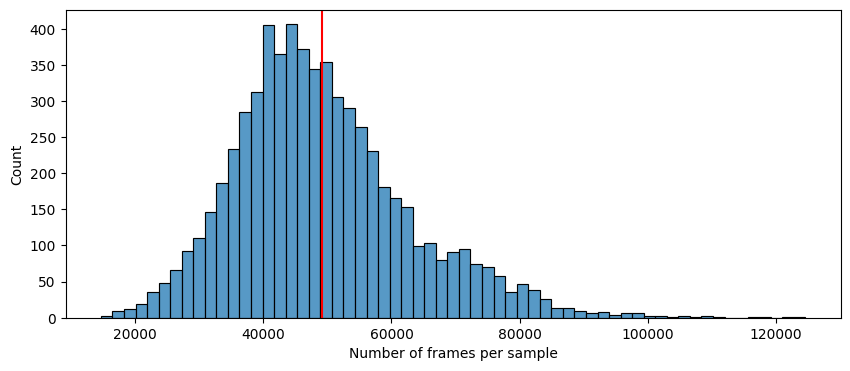

In [2]:
wav_paths = [path for path in glob.glob(main_dir + "/*/*/*.wav") 
    if not (path.endswith("_1.wav") or path.endswith("_2.wav"))]
frames = [len(librosa.load(wav_path, sr=16000)[0]) for wav_path in tqdm(wav_paths)]
print("Max frames:", np.max(frames))

plt.figure(figsize=(10,4))
sns.histplot(data=frames)
plt.axvline(x=np.mean(frames), color='red')
plt.xlabel("Number of frames per sample")
plt.show()

## Split

In [3]:
cutoff_limit = 70000
outlier, split_files, frames = [], [], []
for wav_path in tqdm(wav_paths):
    y = librosa.load(wav_path, sr=16000)[0]
    n_frames = len(y)
    frames.append(n_frames)
    if n_frames >= cutoff_limit:
        phn_path = wav_path.replace("wav", "phn")
        lines = open(phn_path, "r").readlines()
        end = np.array([int(line.split()[1]) for line in lines])
        try: 
            idx = np.where(end < n_frames//2)[0][-1]
            lines_1 = lines[:idx]
            lines_2 = lines[idx:]
            factor = int(lines_2[0].split()[0])
            for i, line in enumerate(lines_2):
                start, end, phoneme = line.split()
                start = int(start) - factor
                end = int(end) - factor
                line = " ".join([str(start), str(end), phoneme + "\n"])
                lines_2[i] = line
            f1_path = os.path.splitext(phn_path)[0] + "_1.phn"
            f2_path = os.path.splitext(phn_path)[0] + "_2.phn"
            for path, lines in zip([f1_path, f2_path], [lines_1, lines_2]):
                with open(path, "w") as f:
                    f.writelines(lines)    
            sf.write(f1_path.replace("phn", "wav"), y[:factor], 16000)
            sf.write(f2_path.replace("phn", "wav"), y[factor:], 16000)
            split_files.append(wav_path)
        except:
            outlier.append(wav_path)
            pass

print("Outliers:\n", outlier)

  0%|          | 0/6300 [00:00<?, ?it/s]

Outliers:
 ['Datasets\\TIMIT-dataset\\data\\DR2\\MCCS0\\SX29.wav']


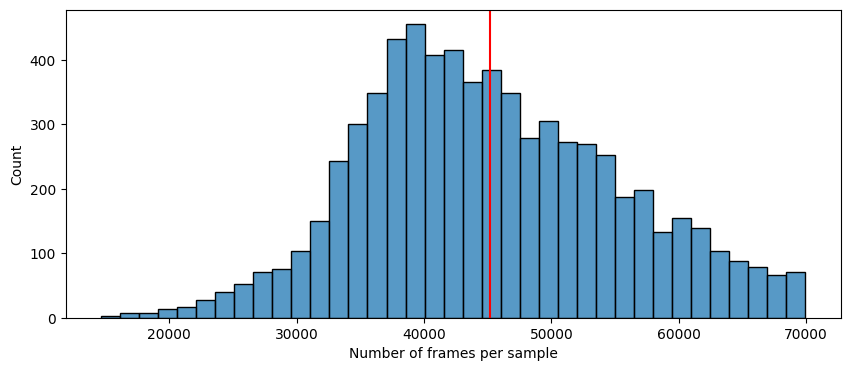

In [4]:
wav_paths = glob.glob(main_dir + "/*/*/*.wav")
wav_paths = [path for path in wav_paths if not path in (split_files + outlier)]
frames = []
for wav_path in wav_paths:
    y = librosa.load(wav_path, sr=16000)[0]
    n_frames = len(y)
    frames.append(n_frames)

plt.figure(figsize=(10,4))
sns.histplot(data=frames)
plt.axvline(x=np.mean(frames), color='red')
plt.xlabel("Number of frames per sample")
plt.show()

## Padding

In [5]:
wav_paths = glob.glob(main_dir + "/*/*/*.wav")
wav_paths = [path for path in wav_paths 
    if not path in (split_files + outlier)]
    
for wav_path in tqdm(wav_paths):
    y = librosa.load(wav_path, sr=16000)[0]
    n_frames = len(y)
    y_sil = np.array([])
    if n_frames != cutoff_limit:
        pad_length = cutoff_limit - n_frames

        with open(wav_path.replace("wav", "phn"), "r") as f:
            lines = f.readlines()
        phonemes = np.array([line.split()[-1] for line in lines])
        for i in np.where(phonemes == "h#")[0]:
            start_sil, end_sil = list(map(int, lines[i].split()[:-1]))
            y_sil = np.concatenate([y_sil, y[start_sil:end_sil]])
        
        if len(y_sil) >= pad_length:
            y_sil = y_sil[:pad_length]
        else:
            extension = pad_length - len(y_sil)
            y_sil = np.pad(y_sil, (0, extension), mode='wrap')
        
        np.random.shuffle(y_sil)
        y = np.concatenate([y, y_sil])
        
        start, end, phoneme = lines.pop(-1).split()
        if lines[-1].split()[-1] == "h#":
            line = " ".join([end, str(cutoff_limit), phoneme])
        else:
            line = " ".join([start, str(cutoff_limit), "h#\n"])
        lines.append(line)

        with open(wav_path.replace("wav", "phn"), "w") as f:
            f.writelines(lines)

        sf.write(wav_path, y, 16000)

    else:
        pass

  0%|          | 0/6862 [00:00<?, ?it/s]

In [6]:
d = pd.read_csv("Datasets\TIMIT-dataset\data.csv")
d

,wav_paths
0,Datasets\TIMIT-dataset\data\DR1\FAKS0\SA1.wav
1,Datasets\TIMIT-dataset\data\DR1\FAKS0\SA2.wav
2,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI1573_1...
3,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI1573_2...
4,Datasets\TIMIT-dataset\data\DR1\FAKS0\SI2203.wav
...,...
6857,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX172.wav
6858,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX262.wav
6859,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX352.wav
6860,Datasets\TIMIT-dataset\data\DR8\MTCS0\SX442.wav


# TFrecords

## Write

In [7]:
class TFRWriter():
    def __init__(self, paths, n_splits=5):
        self.samples = paths
        self.n_splits = n_splits
        self.sample_rate = 16000
        self.padding_length = 80000
        self.phoneme_dict = self.get_dict()


    def shards(self):
        speaker_id = [sample.split('\\')[4] for sample in self.samples]
        skf = StratifiedKFold(
            n_splits=self.n_splits, shuffle=True, random_state=42)
        return [
            list(map(lambda x: self.samples[x], j)) 
            for i, j in skf.split(self.samples, speaker_id)]


    def get_dict(self):
        phonemes = set()
        for sample in self.samples:
            base_path = os.path.splitext(sample)[0]
            with open(base_path + '.phn', "r") as f:
                for line in f.readlines():
                    phonemes.add(line.split()[-1])
        phonemes = sorted(Counter(phonemes), key=Counter(phonemes).get, reverse=True)
        phonemes_dict = {v: i for i, v in enumerate(phonemes)}
        with open("Datasets\TIMIT-dataset\phoneme_dict.json", "w") as f:
            json.dump(phonemes_dict, f, sort_keys=False, indent=4)
        return phonemes_dict

    
    def get_framewise_label(self, p_frames, phonemes):
        label = []
        for i in range(1, len(p_frames)):
            for j in range(p_frames[i-1], p_frames[i]):
                label.append(phonemes[i-1])
        label = list(map(self.phoneme_dict.get, label))
        label = tf.convert_to_tensor(label)
        return tf.io.serialize_tensor(label)


    def get_binary_label(self, p_frames):
        mask = np.zeros(p_frames[-1], dtype=int)
        p_frames[-1] -= 1
        for i in p_frames:
            mask[i] = 1
        mask = tf.convert_to_tensor(mask)
        return tf.io.serialize_tensor(mask)


    def get_shard_data(self, samples, shard):
        for sample in tqdm(
                samples, total=len(samples), desc=f"Writing shard {shard}"):
            base_path = os.path.splitext(sample)[0]
            p_frames, phonemes = [0], []
            with open(base_path + ".phn") as f:
                for line in f.readlines():
                    p_frame, phoneme = line.split()[1::]
                    p_frames.append(int(p_frame))
                    phonemes.append(str(phoneme))
            audio = tf.io.read_file(base_path + ".wav")
            framewise_label = self.get_framewise_label(p_frames, phonemes)
            binary_label = self.get_binary_label(p_frames)
            filename = str.encode("/".join(sample.split('\\')[-3::]))
            yield {
                "audio": audio,
                "framewise_label": framewise_label,
                "binary_label": binary_label,
                "filename": filename}


    def _bytes_feature(self, value):
        """Returns a bytes_list from a string / byte."""
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


    def _float_feature(self, value):
        """Returns a float_list from a float / double."""
        return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


    def _int64_feature(self, value):
        """Returns an int64_list from a bool / enum / int / uint."""
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


    def serialize_example(self, *args):
        feature = {
            'audio': self._bytes_feature(args[0]),
            'framewise_label': self._bytes_feature(args[1]),
            'binary_label': self._bytes_feature(args[2]),
            'filename': self._bytes_feature(args[3])}

        example_proto = tf.train.Example(
            features=tf.train.Features(feature=feature))
        return example_proto.SerializeToString()


    def write(self):
        for shard, samples in enumerate(self.shards()):
            with tf.io.TFRecordWriter(
                    f"Datasets/TIMIT-dataset/tfrec_data/train_{shard+1}.tfrec") as f:
                for sample in self.get_shard_data(samples, shard+1):
                    example = self.serialize_example(
                        sample['audio'], sample['framewise_label'], 
                        sample['binary_label'], sample['filename'])
                    f.write(example)


TFRWriter(paths=d['wav_paths'].tolist()).write()

Writing shard 1:   0%|          | 0/1373 [00:00<?, ?it/s]

Writing shard 2:   0%|          | 0/1373 [00:00<?, ?it/s]

Writing shard 3:   0%|          | 0/1372 [00:00<?, ?it/s]

Writing shard 4:   0%|          | 0/1372 [00:00<?, ?it/s]

Writing shard 5:   0%|          | 0/1372 [00:00<?, ?it/s]

## Loading

In [8]:
def read_tfrecord(example):
    feature_description = {
        'audio': tf.io.FixedLenFeature([], tf.string),
        'framewise_label': tf.io.FixedLenFeature([], tf.string),
        'binary_label': tf.io.FixedLenFeature([], tf.string),
        'filename': tf.io.FixedLenFeature([], tf.string)}
    
    example = tf.io.parse_single_example(example, feature_description)
    example['audio'] = tf.audio.decode_wav(example['audio'])[0]
    example['framewise_label'] = tf.io.parse_tensor(
        example['framewise_label'], out_type=tf.int32)
    example['binary_label'] = tf.io.parse_tensor(
        example['binary_label'], out_type=tf.int32)
    return example

raw_dataset = tf.data.TFRecordDataset(r"Datasets/TIMIT-dataset/tfrec_data/train_1.tfrec")

for raw_record in raw_dataset.take(1):
    example = read_tfrecord(raw_record)
    print(example)

{'audio': <tf.Tensor: shape=(70000, 1), dtype=float32, numpy=
array([[6.1035156e-05],
       [1.8310547e-04],
       [9.1552734e-05],
       ...,
       [1.5258789e-04],
       [1.8310547e-04],
       [2.7465820e-04]], dtype=float32)>, 'binary_label': <tf.Tensor: shape=(70000,), dtype=int32, numpy=array([1, 0, 0, ..., 0, 0, 1])>, 'filename': <tf.Tensor: shape=(), dtype=string, numpy=b'DR1/FAKS0/SA2.wav'>, 'framewise_label': <tf.Tensor: shape=(70000,), dtype=int32, numpy=array([53, 53, 53, ..., 53, 53, 53])>}


In [9]:
class TIMITDataset():
    def __init__(self, main_dir):
        self.files = [os.path.join(main_dir, f) for f in os.listdir(main_dir)]
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.BUFFER_SIZE = 512
        self.BATCH_SIZE = 16
        self.SAMPLE_RATE = 16000
        self.N_FFT = 1024
        self.WINDOW_SIZE = 512
        self.HOP_LENGTH = 256
        self.N_MELS = 128
        self.FMIN = 0
        self.FMAX = 8000
        self.TOP_DB = 80
        self.FADE_IN = 1000
        self.FADE_OUT = 2000
        self.train_files, self.test_files = train_test_split(
            self.files, test_size=0.2, shuffle=True)

    def decode_audio(self, audio):
        audio = tf.audio.decode_wav(audio)[0]
        return tf.squeeze(audio, axis=-1)

    def read_tfrecord(self, example):
        feature_description = {
            'audio': tf.io.FixedLenFeature([], tf.string),
            'framewise_label': tf.io.FixedLenFeature([], tf.string),
            'binary_label': tf.io.FixedLenFeature([], tf.string),
            'filename': tf.io.FixedLenFeature([], tf.string)}
        
        example = tf.io.parse_single_example(example, feature_description)
        example['audio'] = self.decode_audio(example['audio'])
        example['framewise_label'] = tf.io.parse_tensor(
            example['framewise_label'], out_type=tf.int32)
        example['binary_label'] = tf.io.parse_tensor(
            example['binary_label'], out_type=tf.int32)
        return example


    def load_dataset(self, files):
        ignore_order = tf.data.Options()
        ignore_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(files)
        dataset = dataset.with_options(ignore_order)
        dataset = dataset.map(
            partial(self.read_tfrecord), 
            num_parallel_calls=self.AUTOTUNE)
        return dataset


    def get_spectrogram(self, sample, training=True):
        waveform = sample['audio'] / 32678.0
        if training == True:
            waveform = tfio.audio.fade(
                waveform, fade_in=self.FADE_IN, 
                fade_out=self.FADE_OUT, mode="logarithmic")
        spectrogram = tf.abs(tfio.audio.spectrogram(
            waveform, nfft=self.N_FFT, window=self.WINDOW_SIZE, 
            stride=self.HOP_LENGTH))
        mel_spectrogram = tfio.audio.melscale(
            spectrogram, rate=self.SAMPLE_RATE, mels=self.N_MELS, 
            fmin=self.FMIN, fmax=self.FMAX)
        mel_spectrogram = tfio.audio.dbscale(
            mel_spectrogram, top_db=self.TOP_DB)
        if training == True:
            mel_spectrogram = tfio.audio.freq_mask(mel_spectrogram, param=7)
            mel_spectrogram = tfio.audio.time_mask(mel_spectrogram, param=10)
        sample['audio'] = mel_spectrogram
        return sample


    def train(self):
        dataset = self.load_dataset(self.train_files)
        dataset = dataset.map(
            partial(self.get_spectrogram, training=True), num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.repeat()
        dataset = dataset.shuffle(self.BUFFER_SIZE)
        dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset


    def test(self):
        dataset = self.load_dataset(self.test_files)
        dataset = dataset.map(
            partial(self.get_spectrogram, training=False), num_parallel_calls=self.AUTOTUNE)
        dataset = dataset.shuffle(self.BUFFER_SIZE)
        dataset = dataset.batch(self.BATCH_SIZE)
        dataset = dataset.cache()
        dataset = dataset.prefetch(self.AUTOTUNE)
        return dataset


main_dir = "Datasets/TIMIT-dataset/tfrec_data"
dataset = TIMITDataset(main_dir).train()
dataset

<PrefetchDataset shapes: {audio: (None, None, 128), binary_label: <unknown>, filename: (None,), framewise_label: <unknown>}, types: {audio: tf.float32, binary_label: tf.int32, filename: tf.string, framewise_label: tf.int32}>

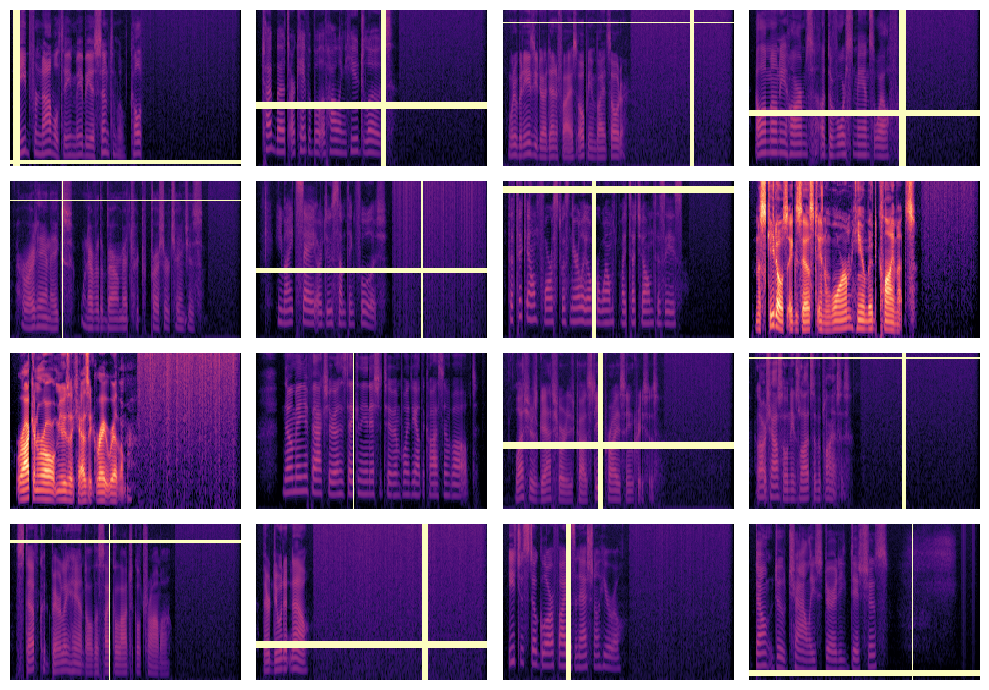

In [10]:
import librosa.display

audio, binary_label, filename, framewise_label,= list(next(iter(dataset)).values())
plt.figure(figsize=(10, 7))
n_samples = audio.shape[0]
row = 4; col = int(n_samples / 4)
for i in range(n_samples):
    plt.subplot(row, col, i+1)
    plt.axis("off")
    librosa.display.specshow(audio[i].numpy().T)

plt.tight_layout()
plt.show()